In [ ]:
import pandas as pd
import numpy as np
# Load the dataset
file_path = 'CABK.MC.csv'
df_CABK = pd.read_csv(file_path)

# Check for missing values
df_CABK.isnull().sum()

df_CABK = df_CABK.interpolate(method='linear', limit_direction='both', axis=0)

In [ ]:
# Convert 'Date' column to datetime if it's not already
df_CABK['Date'] = pd.to_datetime(df_CABK['Date'])

# Set the 'Date' column as the index
df_CABK.set_index('Date', inplace=True)

In [ ]:
def calculate_rsi(data, window=14):
    """
    Calculate the Relative Strength Index (RSI) for a given data set and window period.
    Fills initial NaN values with the first valid RSI value.

    :param data: Pandas Series containing the stock prices.
    :param window: The period to calculate the RSI over. Default is 14.
    :return: Pandas Series containing the RSI.
    """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    # Fill initial NaN values
    first_valid = rsi.first_valid_index()
    rsi[:first_valid] = rsi[first_valid]

    return rsi

# Apply the modified RSI calculation
df_CABK['RSI'] = calculate_rsi(df_CABK['Close'])

# Check for NaN values after handling RSI
print("NaNs in df_CABK after handling RSI:", df_CABK.isnull().any().any())

NaNs in df_CABK after handling RSI: False


In [ ]:
# Calculate RSI
df_CABK['RSI'] = calculate_rsi(df_CABK['Close'])

In [ ]:
# Handling NaN values if necessary
df_CABK['RSI'].fillna(method='bfill', inplace=True)  # Backward fill

In [ ]:
import tensorflow as tf
import numpy as np

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select features (Close and RSI) and scale them
scaler = MinMaxScaler(feature_range=(0, 1))
selected_features = df_CABK[['Close', 'RSI']]  # Assuming RSI is added to df_CABK
scaled_features = scaler.fit_transform(selected_features)


In [ ]:
# Define the size of the training dataset
train_size = int(len(scaled_features) * 0.8)

# Split the data into training and testing datasets
train_data, test_data = scaled_features[:train_size, :], scaled_features[train_size:, :]

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])  # Assuming 'Close' is the target
    return np.array(dataX), np.array(dataY)

# Create training and testing datasets
look_back = 1
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
def create_model(units=40):
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 2)))  # 2 features: Close and RSI
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    return model


In [ ]:
from sklearn.metrics import mean_squared_error

units_options = np.arange(40, 80, 10)
epochs_options = [100, 150]

best_score = float('inf')
best_params = {}
best_rmse = float('inf')
best_mape = float('inf')

for units in units_options:
    for epochs in epochs_options:
        tf.keras.backend.clear_session()
        model = create_model(units)
        model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=0)

        predictions = model.predict(testX).flatten()
        mse = mean_squared_error(testY.flatten(), predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((testY.flatten() - predictions) / testY.flatten())) * 100

        if mse < best_score or (mse == best_score and (rmse < best_rmse or mape < best_mape)):
            best_score = mse
            best_rmse = rmse
            best_mape = mape
            best_params = {'units': units, 'epochs': epochs}

        print(f"Tested: Units={units}, Epochs={epochs}, MSE={mse}, RMSE={rmse}, MAPE={mape}%")

print("Best Model: MSE = %f, RMSE = %f, MAPE = %f using %s" % (best_score, best_rmse, best_mape, best_params))


16/16 [==============================] - 1s 3ms/step
Tested: Units=40, Epochs=100, MSE=0.00044433299404166753, RMSE=0.021079207623667155, MAPE=3.0264020229419266%
16/16 [==============================] - 0s 2ms/step
Tested: Units=40, Epochs=150, MSE=0.00042872507467108374, RMSE=0.02070567735359275, MAPE=2.9132523843204083%
16/16 [==============================] - 0s 2ms/step
Tested: Units=50, Epochs=100, MSE=0.0004463851702160053, RMSE=0.021127829283104436, MAPE=3.0319712468086237%
16/16 [==============================] - 1s 2ms/step
Tested: Units=50, Epochs=150, MSE=0.0004310649475475275, RMSE=0.02076210363974536, MAPE=2.922182899687497%
16/16 [==============================] - 1s 2ms/step
Tested: Units=60, Epochs=100, MSE=0.0004459949566420089, RMSE=0.021118592676644173, MAPE=3.0316297898203195%
16/16 [==============================] - 0s 2ms/step
Tested: Units=60, Epochs=150, MSE=0.0004252365121109266, RMSE=0.020621263591519473, MAPE=2.901595761383892%
16/16 [=======================

In [16]:
tf.keras.backend.clear_session()

best_units = best_params['units']
best_epochs = best_params['epochs']
model_best = create_model(units=best_units)

model_best.fit(trainX, trainY, epochs=best_epochs, batch_size=1, verbose=1)

Epoch 1/150
2046/2046 [==============================] - 8s 3ms/step - loss: 0.0115
Epoch 2/150
2046/2046 [==============================] - 12s 6ms/step - loss: 5.1396e-04
Epoch 3/150
2046/2046 [==============================] - 13s 7ms/step - loss: 4.7504e-04
Epoch 4/150
2046/2046 [==============================] - 12s 6ms/step - loss: 4.8249e-04
Epoch 5/150
2046/2046 [==============================] - 5s 3ms/step - loss: 4.8419e-04
Epoch 6/150
2046/2046 [==============================] - 6s 3ms/step - loss: 4.5188e-04
Epoch 7/150
2046/2046 [==============================] - 7s 3ms/step - loss: 4.5895e-04
Epoch 8/150
2046/2046 [==============================] - 7s 3ms/step - loss: 4.5100e-04
Epoch 9/150
2046/2046 [==============================] - 6s 3ms/step - loss: 4.6530e-04
Epoch 10/150
2046/2046 [==============================] - 6s 3ms/step - loss: 4.4912e-04
Epoch 11/150
2046/2046 [==============================] - 7s 3ms/step - loss: 4.5980e-04
Epoch 12/150
2046/2046 [=======

In [17]:
# Make predictions on the test dataset
testPredictions = model_best.predict(testX).flatten()

# Inverse transform to get the original scale of stock prices
testY_original = scaler.inverse_transform(np.column_stack([testY, np.zeros_like(testY)]))[:, 0]
testPredictions_original = scaler.inverse_transform(np.column_stack([testPredictions, np.zeros_like(testPredictions)]))[:, 0]


16/16 [==============================] - 0s 2ms/step


In [18]:
# Calculate MSE, RMSE, and MAPE using the original scale values
mse = mean_squared_error(testY_original, testPredictions_original)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((testY_original - testPredictions_original) / testY_original)) * 100

# Output the performance metrics
print(f'Mean Squared Error (MSE) on Original Scale: {mse}')
print(f'Root Mean Squared Error (RMSE) on Original Scale: {rmse}')
print(f'Mean Absolute Percentage Error (MAPE) on Original Scale: {mape}%')

Mean Squared Error (MSE) on Original Scale: 0.0049119333423385
Root Mean Squared Error (RMSE) on Original Scale: 0.07008518632591698
Mean Absolute Percentage Error (MAPE) on Original Scale: 1.5473874142290518%


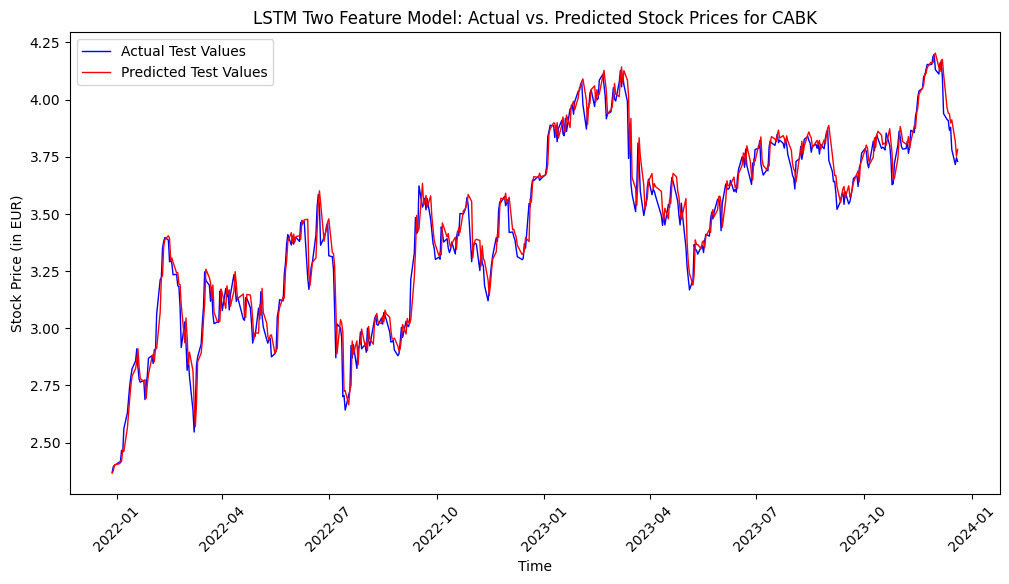

In [19]:
import matplotlib.pyplot as plt
test_dates = df_CABK.index[train_size + look_back + 1:len(df_CABK)]
# df_BBVA.index[train_size + look_back + 1:len(df_BBVA)]




# Plotting with the original scale
plt.figure(figsize=(12,6))
plt.plot(test_dates, testY_original, label='Actual Test Values', color='blue', linewidth=1)
plt.plot(test_dates, testPredictions_original, label='Predicted Test Values', color='red', linewidth=1)
plt.title('LSTM Two Feature Model: Actual vs. Predicted Stock Prices for CABK')
plt.xlabel('Time')
plt.ylabel('Stock Price (in EUR)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

